# Upgrade Tensorflow, Persiapan Pustaka, dan Dataset

In [ ]:
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.6/620.6 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 67.7 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is inc

## Menghubungkan pada GDRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import PIL
from glob import glob
import re
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

# Membuat filepath

In [ ]:
DIR = "/content/drive/MyDrive/Dataset medis Thorax RS Soerojo Magelang_Resize/Data Pelatihan Model_Resize"

# Path X-ray dan Mask
xray_dir = os.path.join(DIR, "X-Ray")
mask_dir = os.path.join(DIR, "Mask")

# Ambil semua gambar X-ray dan mask
lung_image_paths = glob(os.path.join(xray_dir, "*.png")) + glob(os.path.join(xray_dir, "*.PNG"))
mask_image_paths = glob(os.path.join(mask_dir, "*.PNG")) + glob(os.path.join(mask_dir, "*.png"))

# Cek jumlah
print(f"Found {len(lung_image_paths)} X-ray images and {len(mask_image_paths)} masks.")

Found 1000 X-ray images and 1000 masks.


In [ ]:
related_paths = defaultdict(list)

# Cek kesesuaian antara file X-ray dan Mask berdasarkan nama file
for img_path in lung_image_paths:
    # Ambil nama file dari path X-ray (tanpa .png)
    img_name = os.path.basename(img_path).replace('.png', '')  # Misal: "Data (72)"

    # Ekstrak nomor di dalam tanda kurung dari nama file X-ray
    img_number = img_name.split('(')[-1].split(')')[0].strip()  # Mengambil '72'

    for mask_path in mask_image_paths:
        # Ambil nama file dari path Mask (tanpa .PNG)
        mask_name = os.path.basename(mask_path).replace('.PNG', '')  # Misal: "mask_Data (379)"

        # Ekstrak nomor di dalam tanda kurung dari nama file Mask
        mask_number = mask_name.split('(')[-1].split(')')[0].strip()  # Mengambil '379'

        # Cek apakah nomor di dalam tanda kurung cocok
        if img_number == mask_number:
            # Jika cocok, simpan path gambar dan mask
            related_paths["image_path"].append(img_path)
            related_paths["mask_path"].append(mask_path)

# Konversi hasil pencocokan ke dalam DataFrame
paths_df = pd.DataFrame.from_dict(related_paths)

# Cek apakah DataFrame berisi data
print(paths_df.head())

                                          image_path  \
0  /content/drive/MyDrive/Dataset medis Thorax RS...   
1  /content/drive/MyDrive/Dataset medis Thorax RS...   
2  /content/drive/MyDrive/Dataset medis Thorax RS...   
3  /content/drive/MyDrive/Dataset medis Thorax RS...   
4  /content/drive/MyDrive/Dataset medis Thorax RS...   

                                           mask_path  
0  /content/drive/MyDrive/Dataset medis Thorax RS...  
1  /content/drive/MyDrive/Dataset medis Thorax RS...  
2  /content/drive/MyDrive/Dataset medis Thorax RS...  
3  /content/drive/MyDrive/Dataset medis Thorax RS...  
4  /content/drive/MyDrive/Dataset medis Thorax RS...  


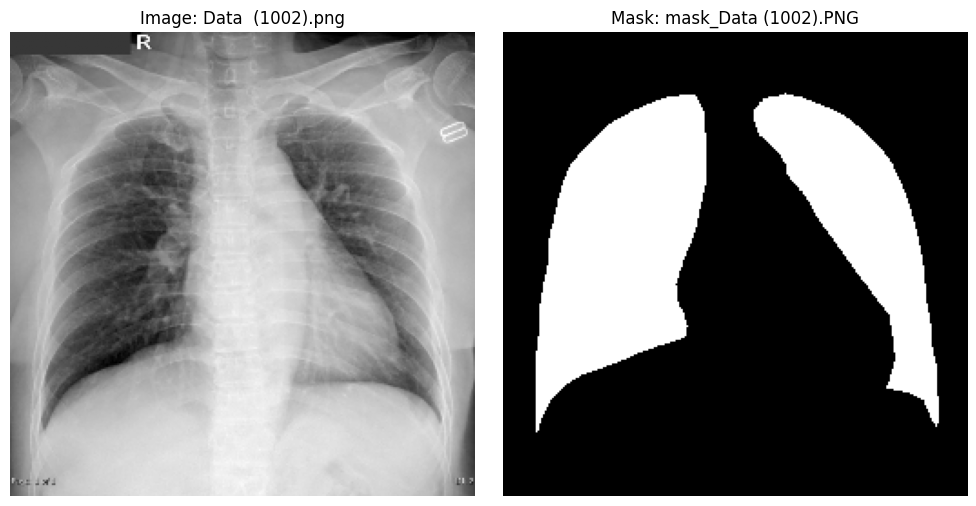

In [ ]:
def display_image_mask(df, index):
  if index < 0 or index >= len(df):
    print(f"Index {index} out of bounds.")
    return

  img_path = df.loc[index, 'image_path']
  mask_path = df.loc[index, 'mask_path']

  try:
    img = PIL.Image.open(img_path)
    mask = PIL.Image.open(mask_path)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title(f"Image: {os.path.basename(img_path)}")
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray') # Mask biasanya binary atau grayscale
    axes[1].set_title(f"Mask: {os.path.basename(mask_path)}")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

  except FileNotFoundError:
    print(f"File not found for index {index}. Image path: {img_path}, Mask path: {mask_path}")
  except Exception as e:
    print(f"An error occurred: {e}")
display_image_mask(paths_df, 1)

In [ ]:
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm

def prepare_train_test(df=pd.DataFrame(), color_mode="gray"):
    img_array = []
    mask_array = []

    # Proses gambar
    for image_path in tqdm(df.image_path, desc="Loading images"):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = image / 255.0
        img_array.append(image)

    # Proses mask
    for mask_path in tqdm(df.mask_path, desc="Loading masks"):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = mask / 255.0
        mask_array.append(mask)

    # Konversi ke NumPy array
    img_array = np.array(img_array)
    mask_array = np.array(mask_array)
    return img_array, mask_array

img_array, mask_array = prepare_train_test(df=paths_df, color_mode="gray")

print(f"Image array shape: {img_array.shape}")
print(f"Mask array shape: {mask_array.shape}")

Loading masks: 100%|██████████| 1000/1000 [11:19<00:00,  1.47it/s]


Image array shape: (1000, 256, 256)
Mask array shape: (1000, 256, 256)


# Inisiasi Model

In [ ]:
from sklearn.model_selection import train_test_split
img_train, img_test, mask_train, mask_test = train_test_split(img_array, mask_array, test_size = 0.2, random_state= 42)

img_side_size = 256
img_train = np.array(img_train).reshape(len(img_train), img_side_size, img_side_size, 1)
img_test = np.array(img_test).reshape(len(img_test), img_side_size, img_side_size, 1)
mask_train = np.array(mask_train).reshape(len(mask_train), img_side_size, img_side_size, 1)
mask_test = np.array(mask_test).reshape(len(mask_test), img_side_size, img_side_size, 1)

In [ ]:
#ubah ke bentuk float32
img_train = img_train.astype('float32')
img_test = img_test.astype('float32')
mask_train = mask_train.astype('float32')
mask_test = mask_test.astype('float32')

In [ ]:
#memastikan bahwa bentuk data adalah float32
print(img_train.dtype)
print(img_test.dtype)
print(mask_train.dtype)
print(mask_test.dtype)

float32
float32
float32
float32


In [ ]:
np.save('/content/drive/MyDrive/img_train_float32.npy', img_train)
np.save('/content/drive/MyDrive/img_test_float32.npy', img_test)
np.save('/content/drive/MyDrive/mask_train_float32.npy', mask_train)
np.save('/content/drive/MyDrive/mask_test_float32.npy', mask_test)


In [ ]:
print(img_train[1])

[[[0.23137255]
  [0.23137255]
  [0.23137255]
  ...
  [0.02745098]
  [0.03529412]
  [0.03529412]]

 [[0.23137255]
  [0.23137255]
  [0.23137255]
  ...
  [0.02745098]
  [0.02745098]
  [0.02745098]]

 [[0.23137255]
  [0.23137255]
  [0.23137255]
  ...
  [0.02352941]
  [0.02745098]
  [0.03137255]]

 ...

 [[0.15294118]
  [0.17254902]
  [0.1882353 ]
  ...
  [0.20784314]
  [0.18431373]
  [0.16470589]]

 [[0.14901961]
  [0.16862746]
  [0.18431373]
  ...
  [0.20392157]
  [0.18431373]
  [0.16862746]]

 [[0.14901961]
  [0.16862746]
  [0.1882353 ]
  ...
  [0.20392157]
  [0.18431373]
  [0.16078432]]]


In [ ]:
print(mask_train[1])

[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]


In [ ]:
print("Ukuran data training (gambar):", img_train.shape)
print("Ukuran data testing (gambar):", img_test.shape)
print("Ukuran data training (mask):", mask_train.shape)
print("Ukuran data testing (mask):", mask_test.shape)

Ukuran data training (gambar): (800, 256, 256, 1)
Ukuran data testing (gambar): (200, 256, 256, 1)
Ukuran data training (mask): (800, 256, 256, 1)
Ukuran data testing (mask): (200, 256, 256, 1)


# Inisiasi dan pelatihan model L-UNET

In [ ]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import tensorflow as tf
from tensorflow.keras.metrics import Precision

In [ ]:
def L_Unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck (256 filters)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)

    # Decoder
    up5 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv4), conv3], axis=3)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5), conv2], axis=3)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv6), conv1], axis=3)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)

    conv8 = Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    return Model(inputs=[inputs], outputs=[conv8])

In [ ]:
#Matrix Evaluasi
binary_iou = tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5)
precision=tf.keras.metrics.Precision()
accuracy=tf.keras.metrics.BinaryAccuracy()

In [ ]:
# fungsi loss Binary Crossentropy
bce = tf.keras.losses.BinaryCrossentropy()

In [ ]:
from tensorflow.keras import backend as K
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
model = L_Unet(input_size=(256, 256, 1))
model.compile(optimizer=Adam(learning_rate=1e-3), loss= bce, metrics=[ accuracy, precision,binary_iou])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 256, 256,  │        320 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 256, 256,  │      9,248 │ conv2d_45[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 128, 128,  │          0 │ conv2d_46[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_47[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 64, 64,    │          0 │ conv2d_48[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_49[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 32, 32,    │          0 │ conv2d_50[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_11… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_51[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_9  │ (None, 64, 64,    │    131,200 │ conv2d_52[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_50[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 64, 64,    │    295,040 │ concatenate_9[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_53[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_10 │ (None, 128, 128,  │     32,832 │ conv2d_54[0][0] 

 Total params: 1,925,025 (7.34 MB)

 Trainable params: 1,925,025 (7.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(x=img_train,
                    y=mask_train,
                    validation_data=(img_test, mask_test),
                    epochs=30,
                    batch_size=16,
                    callbacks=[earlystopping])

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 279ms/step - binary_accuracy: 0.8271 - binary_io_u: 0.3840 - loss: 0.5587 - precision: 0.9580 - val_binary_accuracy: 0.8177 - val_binary_io_u: 0.3895 - val_loss: 0.4092 - val_precision: 0.8779
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 246ms/step - binary_accuracy: 0.8577 - binary_io_u: 0.5546 - loss: 0.3551 - precision: 0.8003 - val_binary_accuracy: 0.8518 - val_binary_io_u: 0.6303 - val_loss: 0.3370 - val_precision: 0.6807
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 238ms/step - binary_accuracy: 0.8847 - binary_io_u: 0.6428 - loss: 0.2853 - precision: 0.8168 - val_binary_accuracy: 0.9124 - val_binary_io_u: 0.7350 - val_loss: 0.2220 - val_precision: 0.8341
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 241ms/step - binary_accuracy: 0.9266 - binary_io_u: 0.7570 - loss: 0.1903 - precision: 0.8932 - val_binary_accuracy: 0.9508 - val_binary_io_u: 0.8355 - val_loss: 0.1376 - val_precision: 0.9366
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 243ms/step - binar

Text(0.5, -0.15, '(C)')

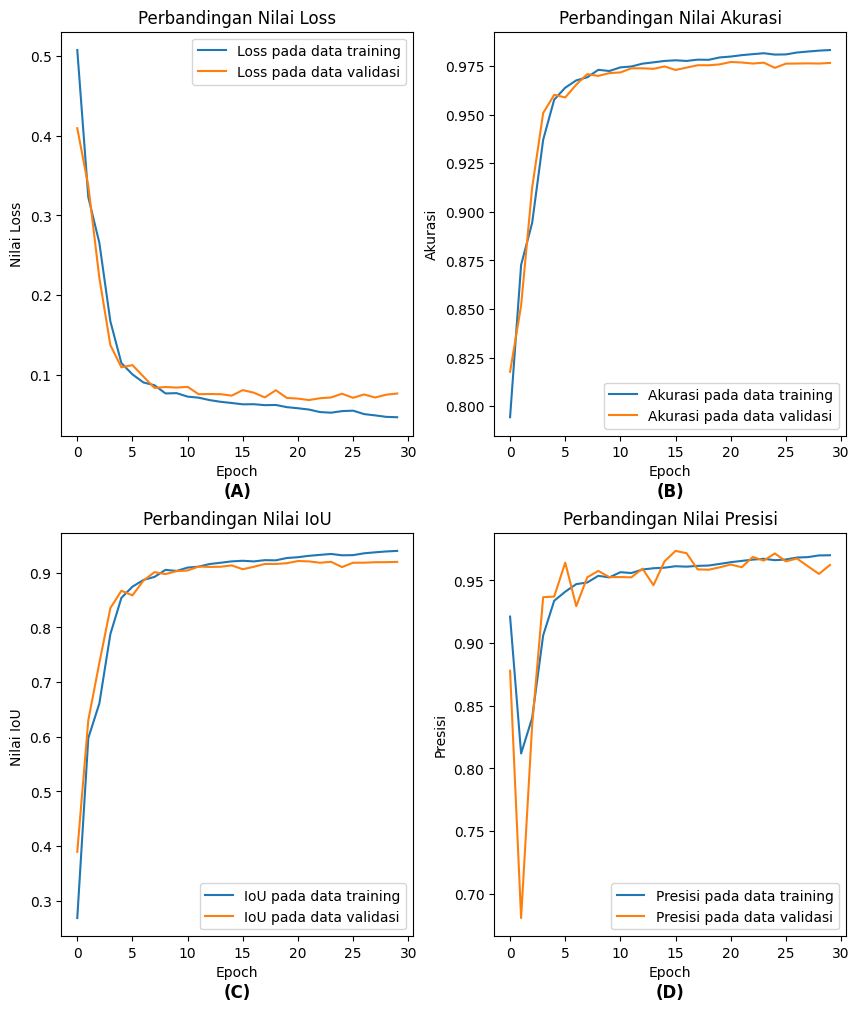

In [ ]:
fig = plt.figure(figsize=(12, 10), constrained_layout=True)

# Plot 1: Loss
plt.subplot(2, 3, 1)
plt.title("Perbandingan Nilai Loss")
plt.plot(history.history["loss"], label="Loss pada data training")
plt.plot(history.history["val_loss"], label="Loss pada data validasi")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Nilai Loss")
plt.text(0.5, -0.15, "(A)", transform=plt.gca().transAxes, fontsize=12, fontweight='bold',ha='center')

# Plot 2: Accuracy
plt.subplot(2, 3, 2)
plt.title("Perbandingan Nilai Akurasi")
plt.plot(history.history["binary_accuracy"], label="Akurasi pada data training")
plt.plot(history.history["val_binary_accuracy"], label="Akurasi pada data validasi")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Akurasi")
plt.text(0.5, -0.15, "(B)", transform=plt.gca().transAxes, fontsize=12, fontweight='bold', ha='center')

# Plot 4: Loss
plt.subplot(2,3,5)
plt.title("Perbandingan Nilai Presisi")
plt.plot(history.history["precision"], label = "Presisi pada data training")
plt.plot(history.history["val_precision"], label = "Presisi pada data validasi")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Presisi")
plt.text(0.5, -0.15, "(D)", transform=plt.gca().transAxes, fontsize=12, fontweight='bold', ha='center')

# Plot 4: IoU
plt.subplot(2, 3, 4)
plt.title("Perbandingan Nilai IoU")
plt.plot(history.history["binary_io_u"], label="IoU pada data training")
plt.plot(history.history["val_binary_io_u"], label="IoU pada data validasi")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Nilai IoU ")
plt.text(0.5, -0.15, "(C)", transform=plt.gca().transAxes, fontsize=12, fontweight='bold', ha='center')

In [ ]:
df_history = pd.DataFrame(history.history)
df_history.to_excel('Hasil pelatihan L-UNet Epoch 30 learning rate 1e-3_BS 16_KEDUA,.xlsx', index=False)

In [ ]:
model.save('LUNet Epoch 30 learning rate 1e-3_BS 16_Fix.h5')

## Visualisasi pengujian di  data test dan validation

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


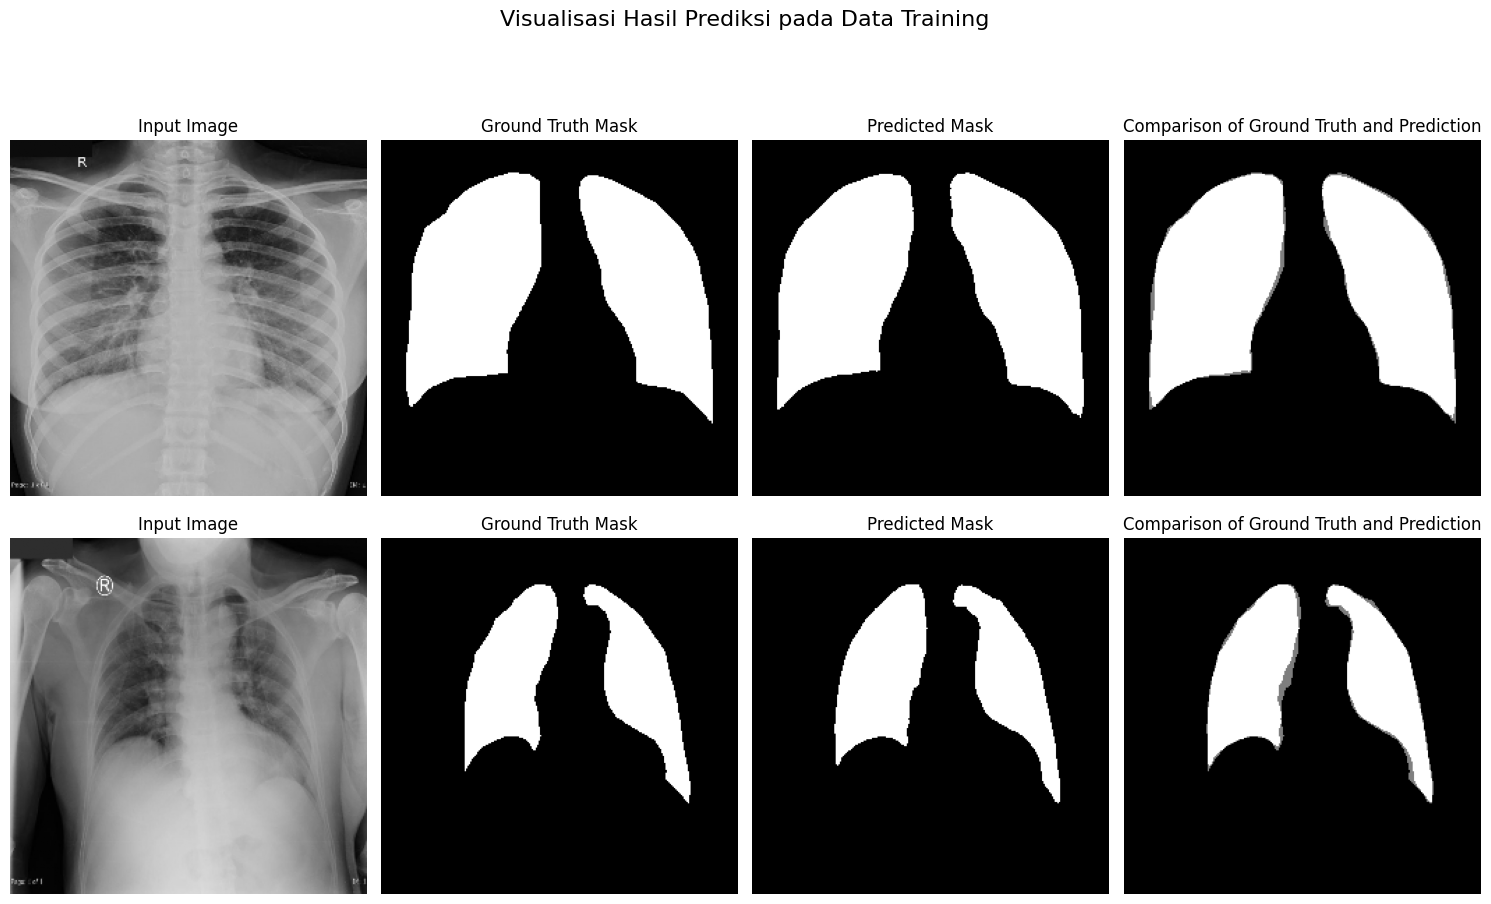

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


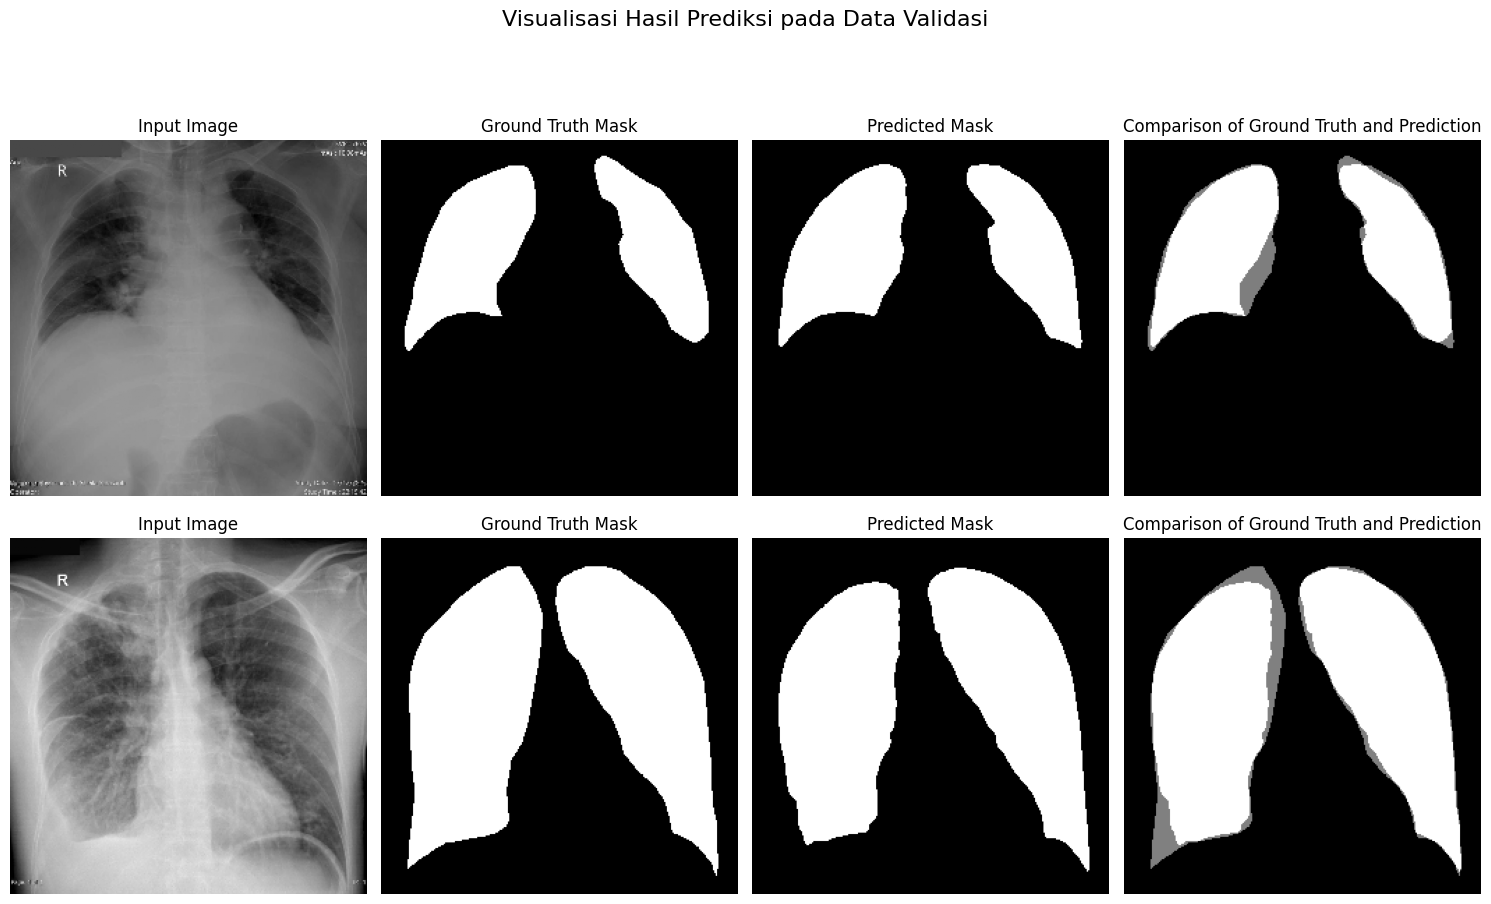

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

def show_predictions(images, masks, title, model, num_samples=2, threshold=0.5):
    plt.figure(figsize=(15, 5 * num_samples))
    plt.suptitle(title, fontsize=16)

    indices = random.sample(range(len(images)), num_samples)

    for i, index in enumerate(indices):
        img = images[index]
        mask = masks[index]

        # Prediksi mask dan threshold
        pred_mask = model.predict(np.expand_dims(img, axis=0))[0]
        pred_mask_bin = (pred_mask > threshold).astype(np.uint8)

        # Plot Input Image
        plt.subplot(num_samples, 4, i * 4 + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title("Input Image")
        plt.axis('off')

        # Plot Ground Truth
        plt.subplot(num_samples, 4, i * 4 + 2)
        plt.imshow(mask.squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        # Plot Predicted Mask
        plt.subplot(num_samples, 4, i * 4 + 3)
        plt.imshow(pred_mask_bin.squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

        # Plot tindih Mask
        plt.subplot(num_samples, 4, i * 4 + 4)
        plt.imshow(mask.squeeze(), cmap='gray')  # Gambar asli (X-ray)
        plt.imshow(pred_mask_bin.squeeze(), cmap='gray', alpha=0.5)  # Mask prediksi dengan transparansi
        plt.title("Comparison of Ground Truth and Prediction")
        plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Contoh penggunaan pada data training dan test:
show_predictions(img_train, mask_train, "Visualisasi Hasil Prediksi pada Data Training", model)
show_predictions(img_test, mask_test, "Visualisasi Hasil Prediksi pada Data Validasi", model)

# Model U-Net

## inisiaisi model

In [ ]:
def unet(input_size=(256,256,1)):
    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
model2 = unet(input_size=(256, 256, 1))
model2.compile(optimizer=Adam(learning_rate=1e-4), loss= bce, metrics=[ accuracy, precision,binary_iou])
model2.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_117 (Conv2D) │ (None, 256, 256,  │        320 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_118 (Conv2D) │ (None, 256, 256,  │      9,248 │ conv2d_117[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 128, 128,  │          0 │ conv2d_118[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_119 (Conv2D) │ (None, 128, 128,  │     18,496 │ max_pooling2d_24… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_120 (Conv2D) │ (None, 128, 128,  │     36,928 │ conv2d_119[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 64, 64,    │          0 │ conv2d_120[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_121 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_25… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_122 (Conv2D) │ (None, 64, 64,    │    147,584 │ conv2d_121[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_26    │ (None, 32, 32,    │          0 │ conv2d_122[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_123 (Conv2D) │ (None, 32, 32,    │    295,168 │ max_pooling2d_26… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_124 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_123[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_27    │ (None, 16, 16,    │          0 │ conv2d_124[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_125 (Conv2D) │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_27… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_126 (Conv2D) │ (None, 16, 16,    │  2,359,808 │ conv2d_125[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_24 │ (None, 32, 32,    │    524,544 │ conv2d_126[0][0]  │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_24      │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 7,759,521 (29.60 MB)

 Trainable params: 7,759,521 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model2.fit(x=img_train,
                    y=mask_train,
                    validation_data=(img_test, mask_test),
                    epochs=30,
                    batch_size=10,
                    callbacks=[earlystopping])

Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 32s 217ms/step - binary_accuracy: 0.7997 - binary_io_u: 0.3643 - loss: 0.6379 - precision: 0.7254 - val_binary_accuracy: 0.7176 - val_binary_io_u: 0.0000e+00 - val_loss: 0.4767 - val_precision: 0.0000e+00
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 191ms/step - binary_accuracy: 0.7498 - binary_io_u: 0.1000 - loss: 0.4147 - precision: 0.5649 - val_binary_accuracy: 0.8840 - val_binary_io_u: 0.6006 - val_loss: 0.2713 - val_precision: 0.9555
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 196ms/step - binary_accuracy: 0.9109 - binary_io_u: 0.7085 - loss: 0.2282 - precision: 0.8918 - val_binary_accuracy: 0.9345 - val_binary_io_u: 0.7835 - val_loss: 0.1738 - val_precision: 0.9219
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 197ms/step - binary_accuracy: 0.9356 - binary_io_u: 0.7859 - loss: 0.1674 - precision: 0.9000 - val_binary_accuracy: 0.9508 - val_binary_io_u: 0.8370 - val_loss: 0.1318 - val_precision: 0.9282
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step

Text(0.5, -0.15, '(C)')

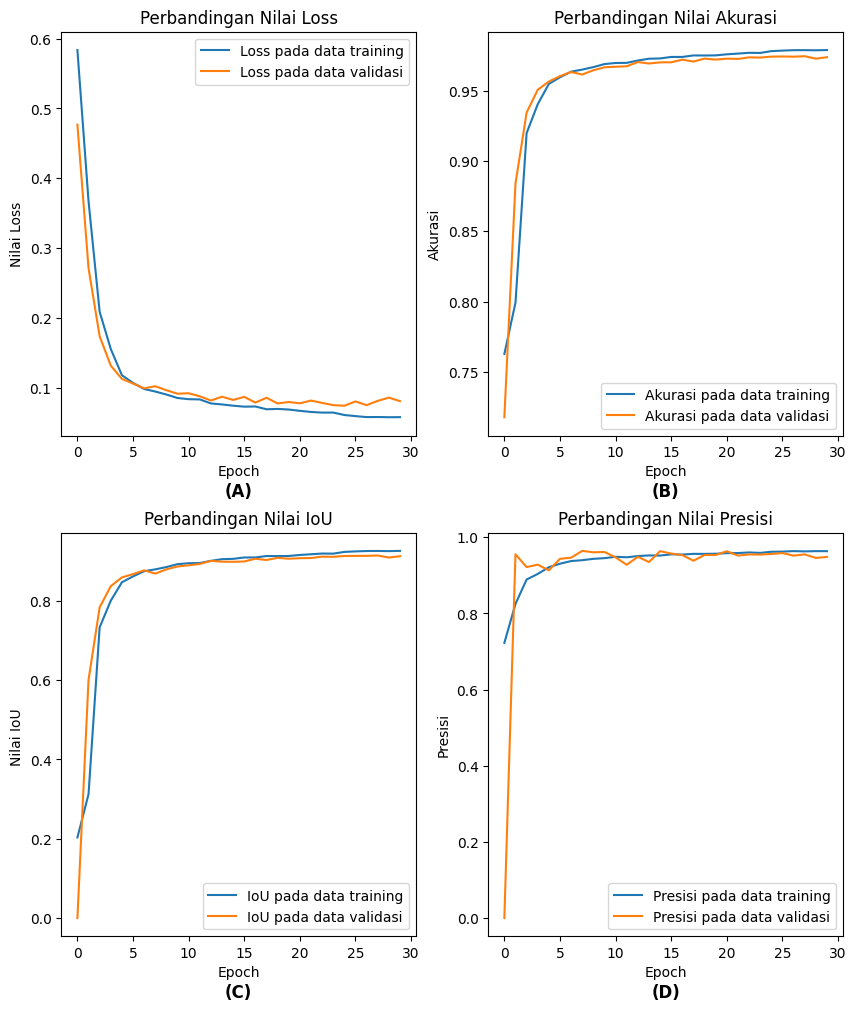

In [ ]:
fig = plt.figure(figsize=(12, 10), constrained_layout=True)

# Plot 1: Loss
plt.subplot(2, 3, 1)
plt.title("Perbandingan Nilai Loss")
plt.plot(history.history["loss"], label="Loss pada data training")
plt.plot(history.history["val_loss"], label="Loss pada data validasi")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Nilai Loss")
plt.text(0.5, -0.15, "(A)", transform=plt.gca().transAxes, fontsize=12, fontweight='bold',ha='center')

# Plot 2: Accuracy
plt.subplot(2, 3, 2)
plt.title("Perbandingan Nilai Akurasi")
plt.plot(history.history["binary_accuracy"], label="Akurasi pada data training")
plt.plot(history.history["val_binary_accuracy"], label="Akurasi pada data validasi")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Akurasi")
plt.text(0.5, -0.15, "(B)", transform=plt.gca().transAxes, fontsize=12, fontweight='bold', ha='center')

# Plot 4: Loss
plt.subplot(2,3,5)
plt.title("Perbandingan Nilai Presisi")
plt.plot(history.history["precision"], label = "Presisi pada data training")
plt.plot(history.history["val_precision"], label = "Presisi pada data validasi")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Presisi")
plt.text(0.5, -0.15, "(D)", transform=plt.gca().transAxes, fontsize=12, fontweight='bold', ha='center')

# Plot 4: IoU
plt.subplot(2, 3, 4)
plt.title("Perbandingan Nilai IoU")
plt.plot(history.history["binary_io_u"], label="IoU pada data training")
plt.plot(history.history["val_binary_io_u"], label="IoU pada data validasi")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Nilai IoU ")
plt.text(0.5, -0.15, "(C)", transform=plt.gca().transAxes, fontsize=12, fontweight='bold', ha='center')

In [ ]:
df_history = pd.DataFrame(history.history)
df_history.to_excel('Hasil pelatihan UNet Epoch 30 learning rate 1e-4_BS 10_Real,.xlsx', index=False)
model2.save('UNet Epoch 30 learning rate 1e-4_BS 10_Real.h5')

## vISUALISSAI TRAIN DAN VALIDASI

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


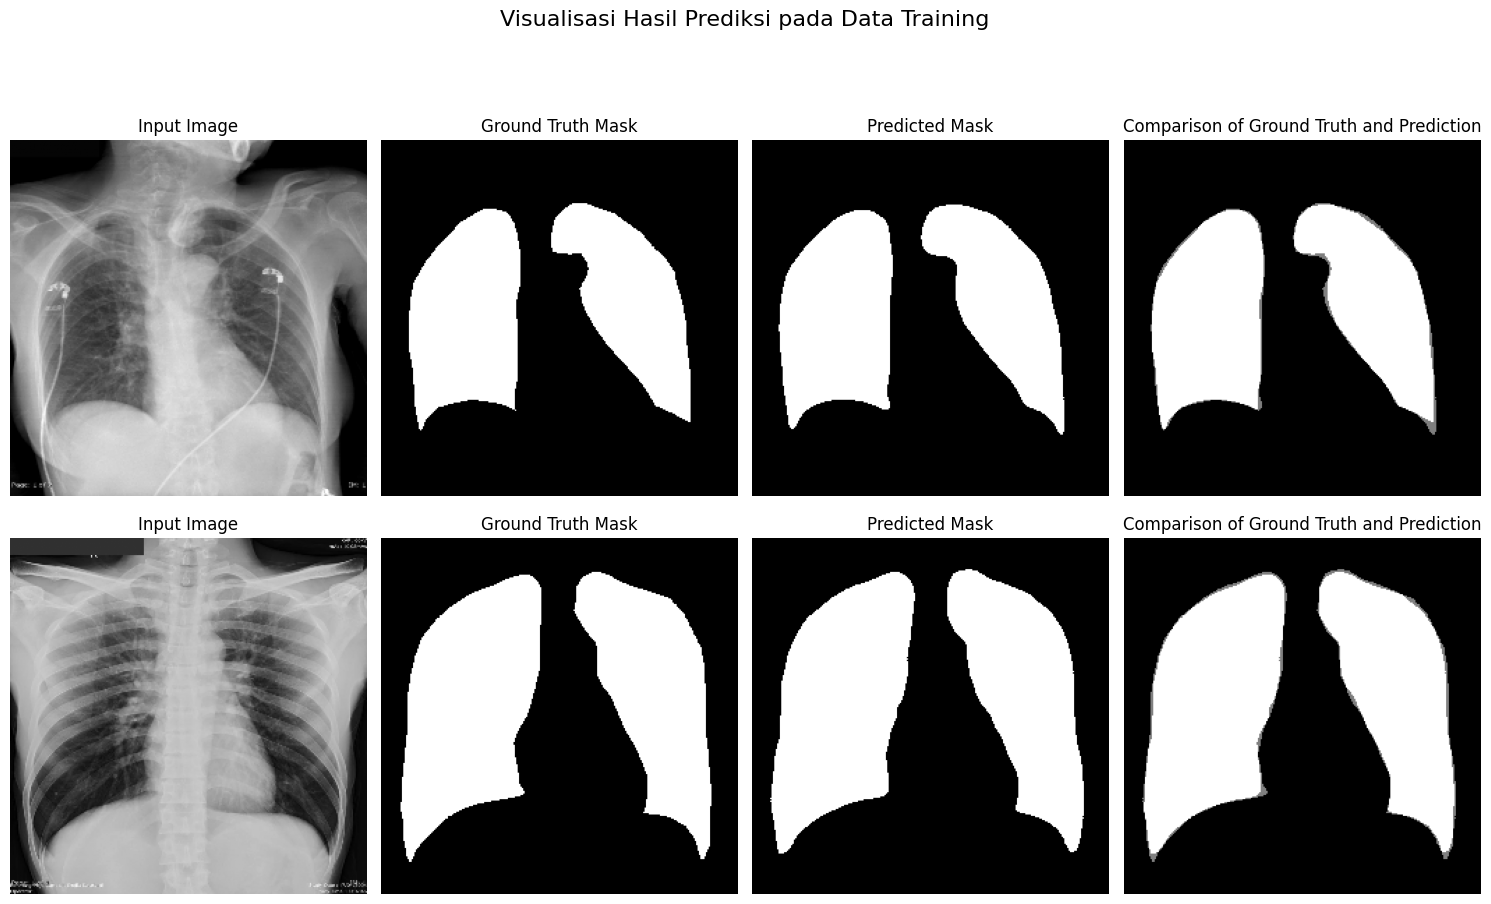

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


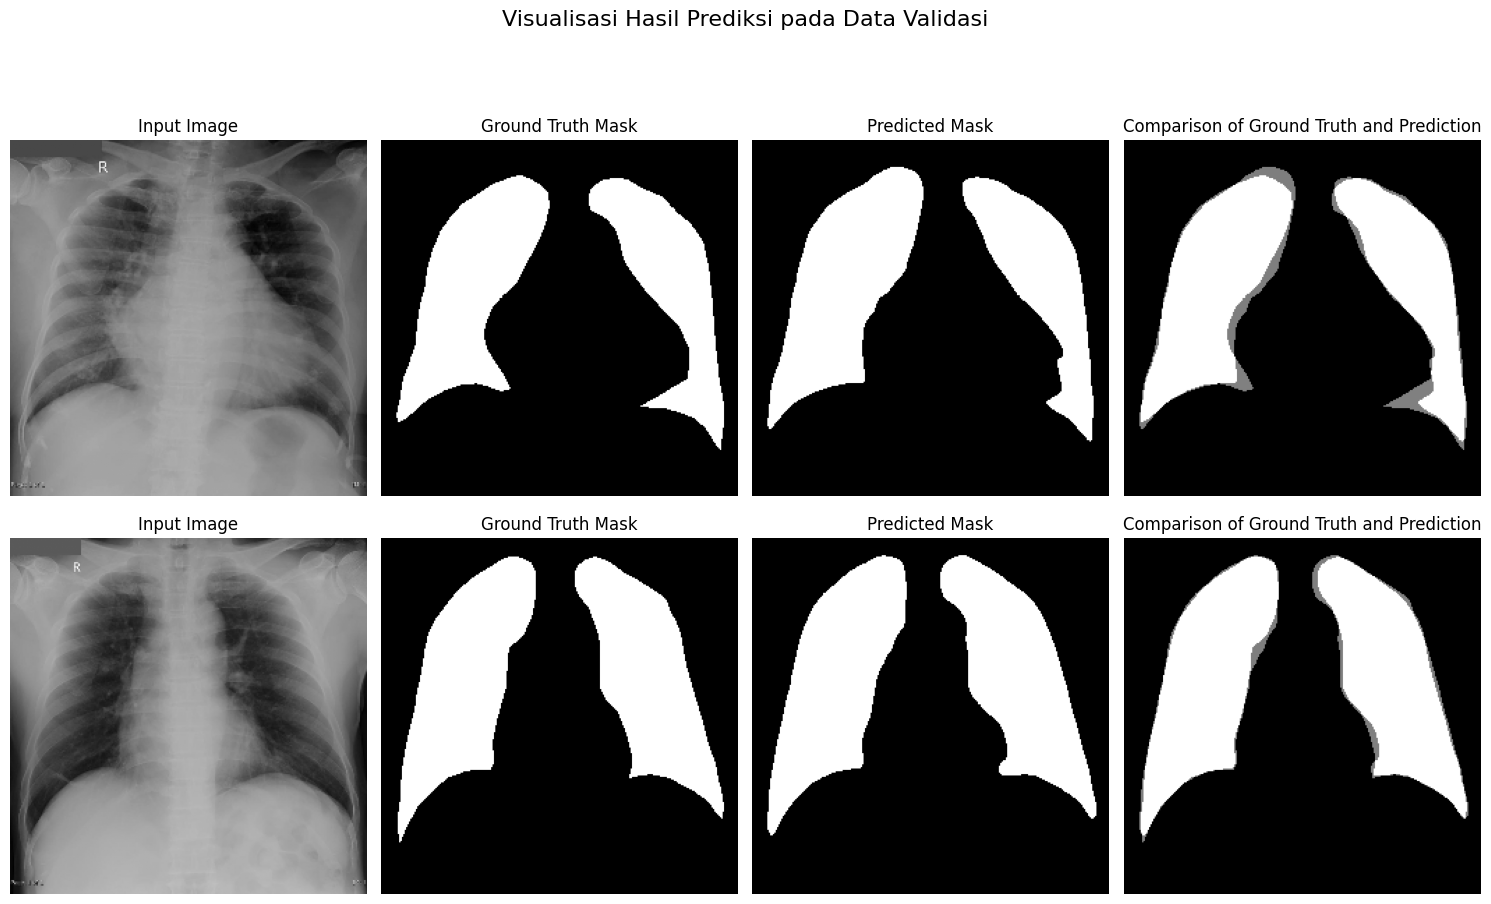

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

def show_predictions(images, masks, title, model, num_samples=2, threshold=0.5):
    plt.figure(figsize=(15, 5 * num_samples))
    plt.suptitle(title, fontsize=16)

    indices = random.sample(range(len(images)), num_samples)

    for i, index in enumerate(indices):
        img = images[index]
        mask = masks[index]

        # Prediksi mask dan threshold
        pred_mask = model2.predict(np.expand_dims(img, axis=0))[0]
        pred_mask_bin = (pred_mask > threshold).astype(np.uint8)

        # Plot Input Image
        plt.subplot(num_samples, 4, i * 4 + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title("Input Image")
        plt.axis('off')

        # Plot Ground Truth
        plt.subplot(num_samples, 4, i * 4 + 2)
        plt.imshow(mask.squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        # Plot Predicted Mask
        plt.subplot(num_samples, 4, i * 4 + 3)
        plt.imshow(pred_mask_bin.squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

        # Plot tindih Mask
        plt.subplot(num_samples, 4, i * 4 + 4)
        plt.imshow(mask.squeeze(), cmap='gray')  # Gambar asli (X-ray)
        plt.imshow(pred_mask_bin.squeeze(), cmap='gray', alpha=0.5)  # Mask prediksi dengan transparansi
        plt.title("Comparison of Ground Truth and Prediction")
        plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Contoh penggunaan pada data training dan test:
show_predictions(img_train, mask_train, "Visualisasi Hasil Prediksi pada Data Training", model2)
show_predictions(img_test, mask_test, "Visualisasi Hasil Prediksi pada Data Validasi", model2)